In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tabulate import tabulate
import pickle
import time

from ga_utils import tokens_to_bow, split, acc_score

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[nltk_data] Downloading package punkt to /Users/devasenan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/devasenan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/devasenan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/devasenan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### data variables

In [2]:
ga_path = '../pickles/ga/30runs/'
kbga_path = '../pickles/kbga/30runs/'
kb_path = "../pickles/kb/"
de_path = '../pickles/de/'
kbde_path = '../pickles/kbde/'


ga_files = ['30_run_az_ga_ts_pt.pkl',
            '30_run_imdb_ga_ts_pt.pkl',
            '30_run_yelp_ga_ts_pt.pkl',
            '30_run_az_ga_ts.pkl',
            '30_run_imdb_ga_ts.pkl',
            '30_run_yelp_ga1_ts.pkl'
            ]

kb_files = ['30_run_az_kbip_ts_pt.pkl',
            '30_run_az_kbps_ts_pt.pkl',
            '30_run_az_kbco_ts_pt.pkl',
            '30_run_az_kbmu_ts_pt.pkl',
            ]

kbga_files = [
            '30_run_az_kbga_vp_ts.pkl',
            '30_run_az_kbga_es50_100_ts.pkl',
            '30_run_imdb_kbga_vp_ts.pkl',
            '30_run_imdb_kbga_es50_100_ts.pkl',
            '30_run_yelp_kbga_vp_ts.pkl',
            '30_run_yelp_kbga_es50_100_ts.pkl',
            ]

de_files = [
            '30_run_az_de.pkl',
            'n_run_az_de_crt.pkl',
            'n_run_az_de_crt1.pkl',
            ]

kbde_files = [
            '30_run_az_kbde.pkl',
            'n_run_az_kbde_crt.pkl',
            'n_run_az_kbde_crt1.pkl',
            ]

In [3]:
rf = open(ga_path+ga_files[0], 'rb')
ga_az = pickle.load(rf)
rf = open(ga_path+ga_files[1], 'rb')
ga_imdb = pickle.load(rf)
rf = open(ga_path+ga_files[2], 'rb')
ga_yelp = pickle.load(rf)

rf = open(kbga_path+kbga_files[0], 'rb')
kbga_az = pickle.load(rf)
rf = open(kbga_path+kbga_files[2], 'rb')
kbga_imdb = pickle.load(rf)
rf = open(kbga_path+kbga_files[4], 'rb')
kbga_yelp = pickle.load(rf)

### functions

In [4]:
def predicted_sentiment_ratio(y_test, predictions):
    positive_percent = np.count_nonzero(predictions==1)*100//len(predictions)
    negative_percent = np.count_nonzero(predictions==0)*100//len(predictions)
    # print(f"Y_test: pos/neg percentage ~ {np.count_nonzero(y_test==1)*100//len(y_test)}, {np.count_nonzero(y_test==0)*100//len(y_test)}")
    return positive_percent, negative_percent

In [5]:
def read_dataset(path):
    dataset = pd.read_csv(path, encoding='latin-1')
    frame = dataset.copy()
    X_bow, features = tokens_to_bow(frame.cmd, 0)
    y_score = frame.score
    return X_bow, y_score

In [6]:
def get_common_genes(file):
    # common_features = np.where(ga_yelp[0][0][-1] == 1)[0]
    common_features = []

    for i in range(len(file)):
        gen100_chromo = file[i][0][-1]
        common_features.extend(np.where(gen100_chromo == 1)[0])
    
    gene_freq = {}
    for i in range(len(common_features)):
        gene = common_features[i]
        gene_freq[gene] = gene_freq.setdefault(gene, 0) + 1

    sorted_gene_freq = np.array(sorted(gene_freq.items(), key=lambda x: x[1], reverse=True))
    return sorted_gene_freq
    # return common_features

In [7]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def fs_model_comparison(dataset_path, data, models, freq_thresh, mode):
    X_bow, y_score = read_dataset(dataset_path)
    X_train, X_test, y_train, y_test = split(X_bow, y_score)

    sorted_gene_freq = get_common_genes(data)
    if mode==0:
        selected_genes = sorted_gene_freq[:freq_thresh, 0]
    elif mode==1:
        selected_genes = [gene for gene, count in sorted_gene_freq if count>=freq_thresh]
    elif mode==2:
        selected_genes = sorted_gene_freq[:, 0]
    
    exec_time = []
    all_accuracy = []
    all_prfs = []
    for logmodel in models:
        # print(logmodel)
        logmodel.fit(X_train[:, selected_genes], y_train)
        st = time.time()
        predictions = logmodel.predict(X_test[:, selected_genes])
        et = time.time()
        exec_time.append(et-st)
        # exec_time.append("{:.3f}s".format(et-st))

        all_accuracy.append(round(accuracy_score(y_test, predictions), 3))
        all_prfs.append(precision_recall_fscore_support(y_test, predictions))
    
    selected_genes.sort()
    return selected_genes, all_accuracy, all_prfs, exec_time

In [8]:
def features_count_percent(tot_features, ga_selected_features, kbga_selected_features):
    nor_features_percent = (tot_features/tot_features)*100
    ga_features_percent = round((len(ga_selected_features)/tot_features)*100)
    kbga_features_percent = round((len(kbga_selected_features)/tot_features)*100)
    return (nor_features_percent, ga_features_percent, kbga_features_percent)

In [9]:
from ga_utils import models, classifiers

def model_comparison(dataset_path, ga, kbga, mode_count=0, freq_thresh=100):
    X_bow, y_score = read_dataset(dataset_path)
    X_train, X_test, y_train, y_test = split(X_bow, y_score)
    
    model_res = acc_score(X_bow, y_score)

    indeces = model_res.iloc[:, 0]
    nor_accuracy = model_res.iloc[:, 1]
    exec_time = model_res.iloc[:, 2]

    sorted_classifiers = dict(zip(classifiers, models))
    sorted_models = sorted(sorted_classifiers.items(), key=lambda x: int(np.where(indeces == x[0])[0][0]))
    sorted_models = [j for i,j in sorted_models]
    
    ga_selected_features, ga_accuracy, ga_prfs, ga_exec_time = fs_model_comparison(dataset_path, ga, sorted_models, freq_thresh, mode_count)
    kbga_selected_features, kbga_accuracy, kbga_prfs, kbga_exec_time = fs_model_comparison(dataset_path, kbga, sorted_models, freq_thresh, mode_count)

    tot_features = X_bow.shape[1]
    features_percents = features_count_percent(tot_features, ga_selected_features, kbga_selected_features)

    print(f'Actual, total number of features count: {X_bow.shape[1]} - {features_percents[0]}%')
    # print("Threshold for gene's frequency:", freq_thresh)
    print(f'Selected features count from GA: {len(ga_selected_features)} - {features_percents[1]}%')
    print(f'Selected features count from KBGA: {len(kbga_selected_features)} - {features_percents[2]}%')

    table_data = {
        'index': indeces,
        'Accuracy': nor_accuracy,
        'Training Time': list(map(lambda x: round(x, 3), exec_time)),
        'GA Accuracy': ga_accuracy,
        'GA - Training Time': list(map(lambda x: round(x, 3), ga_exec_time)),
        'KBGA Accuracy': kbga_accuracy,
        'KBGA - Training Time': list(map(lambda x: round(x, 3), kbga_exec_time)),
    }

    all_features_counts = [X_bow.shape[1], len(ga_selected_features), len(kbga_selected_features)]
    # print(tabulate(table_data, headers='keys', tablefmt="simple_grid"))
    df_table = pd.DataFrame(table_data)
    # print(df_table)
    return table_data, df_table

In [10]:
from sklearn.ensemble import RandomForestClassifier
def dataset_comparison(all_dataset_path, all_ga, all_kbga, mode_count=0, freq_thresh=100):
    
    indeces = ["Amazon", "IMDB", "Yelp"]
    all_nor_accuracy = []
    all_ga_accuracy = []
    all_kbga_accuracy = []
    # all_exec_time = []
    all_tot_features = []
    all_ga_selected_genes = []
    all_kbga_selected_genes = []

    all_nor_prfs = []
    all_ga_prfs = []
    all_kbga_prfs = []

    for i in range(len(all_dataset_path)):
        X_bow, y_score = read_dataset(all_dataset_path[i])
        X_train, X_test, y_train, y_test = split(X_bow, y_score)
        logmodel = RandomForestClassifier(n_estimators=200, random_state=0)
        
        all_tot_features.append(X_bow.shape[1])
        logmodel.fit(X_train,y_train)  
        st = time.time()
        predictions = logmodel.predict(X_test)
        et = time.time()
        nor_accuracy = round(accuracy_score(y_test,predictions), 3)
        nor_prfs = precision_recall_fscore_support(y_test,predictions)
        nor_exec_time = et-st
        ###
        all_nor_accuracy.append(nor_accuracy)
        all_nor_prfs.append(nor_prfs)


        ga_selected_features, ga_accuracy, ga_prfs, ga_exec_time = fs_model_comparison(all_dataset_path[i], all_ga[i], [logmodel], freq_thresh, mode_count)
        kbga_selected_features, kbga_accuracy, kbga_prfs, kbga_exec_time = fs_model_comparison(all_dataset_path[i], all_kbga[i], [logmodel], freq_thresh, mode_count)
        ###
        all_ga_accuracy.append(ga_accuracy[0])
        all_kbga_accuracy.append(kbga_accuracy[0])
        all_ga_selected_genes.append(ga_selected_features)
        all_kbga_selected_genes.append(kbga_selected_features)
        all_ga_prfs.append(ga_prfs)
        all_kbga_prfs.append(kbga_prfs)


    table_data = {
        'index': indeces,
        'Accuracy': all_nor_accuracy,
        "Features Count": all_tot_features,
        'GA Accuracy': all_ga_accuracy,
        "GA Features Count": [len(i) for i in all_ga_selected_genes],
        'KBGA Accuracy': all_kbga_accuracy,
        "KBGA Features Count": [len(i) for i in all_kbga_selected_genes]
    }
    
    # print(tabulate(table_data, headers='keys', tablefmt="simple_grid"))
    df_table = pd.DataFrame(table_data)
    # print(df_table)
    return table_data, df_table, [all_nor_prfs, all_ga_prfs, all_kbga_prfs]

In [11]:
def plot_bargraphs(title, table, hues, ytick):
    bar_width = 0.3
    x = np.arange(len(table['index']))
    y = np.arange(0.0, ytick, 0.1)

    
    fig, ax = plt.subplots(figsize=(12,6))
    bar1 = ax.bar(x-bar_width, height=table[hues[0]], width=bar_width, label=hues[0])
    bar2 = ax.bar(x, height=table[hues[1]], width=bar_width, label=hues[1])
    bar3 = ax.bar(x+bar_width, height=table[hues[2]], width=bar_width, label=hues[2])

    ax.set_ylabel('Fitness Values')
    ax.set_xticks(x, table['index'])
    ax.set_yticks(y)
    ax.legend()
    ax.set_title(title)
    
    ax.bar_label(bar1)
    ax.bar_label(bar2)
    ax.bar_label(bar3)

    # fig.tight_layout()

### Graphs we need

In [12]:
all_dataset_paths = ["../dataset/amazon.csv", "../dataset/imdb.csv", "../dataset/yelp.csv"]
all_ga_data = [ga_az, ga_imdb, ga_yelp]
all_kbga_data = [kbga_az, kbga_imdb, kbga_yelp]

In [18]:
ds_compare_res = dataset_comparison(all_dataset_paths, all_ga_data, all_kbga_data, 2)
ds_compare_res[1]

,index,Accuracy,Features Count,GA Accuracy,GA Features Count,KBGA Accuracy,KBGA Features Count
0,Amazon,0.800,1553,0.756,1242,0.824,942
1,IMDB,0.952,2707,0.941,1485,0.965,1099
2,Yelp,0.704,1763,0.756,1299,0.808,965


In [22]:
ds_compare_res[2][2]

[[(array([0.82905983, 0.81954887]),
   array([0.80165289, 0.84496124]),
   array([0.81512605, 0.83206107]),
   array([121, 129]))],
 [(array([0.93888889, 0.98969072]),
   array([0.98830409, 0.94581281]),
   array([0.96296296, 0.96725441]),
   array([171, 203]))],
 [(array([0.78985507, 0.83035714]),
   array([0.8515625 , 0.76229508]),
   array([0.81954887, 0.79487179]),
   array([128, 122]))]]

Actual, total number of features count: 1553 - 100.0%
Selected features count from GA: 1242 - 80%
Selected features count from KBGA: 942 - 61%


,index,Accuracy,Training Time,GA Accuracy,GA - Training Time,KBGA Accuracy,KBGA - Training Time
0,RandomForest,0.800,0.022,0.756,0.022,0.824,0.021
1,MultinomialNB,0.796,0.003,0.812,0.001,0.832,0.001
2,LinearSVM,0.780,0.033,0.848,0.028,0.832,0.021
3,Logistic,0.776,0.000,0.812,0.001,0.816,0.001
4,DecisionTree,0.772,0.000,0.732,0.001,0.772,0.001
5,RadialSVM,0.756,0.098,0.800,0.080,0.784,0.066
6,KNeighbors,0.648,0.025,0.660,0.021,0.652,0.015


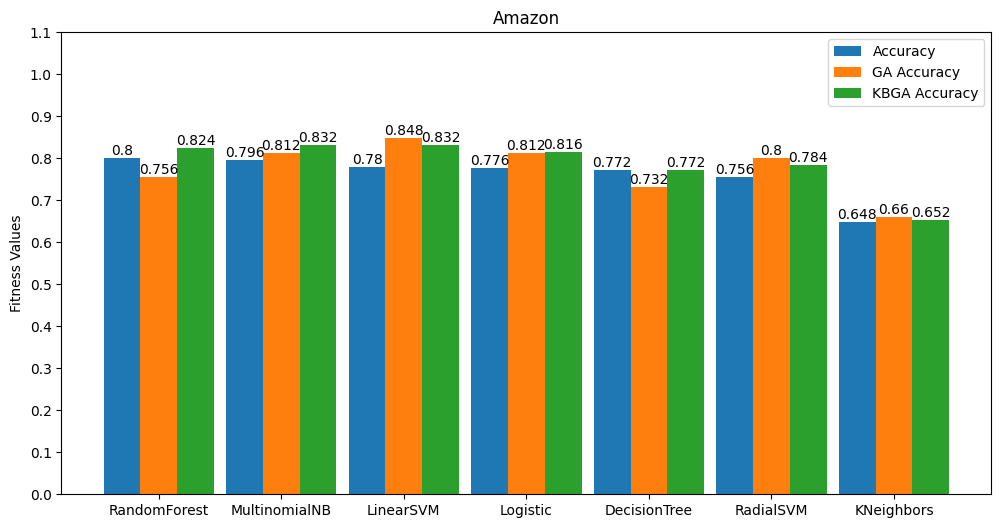

In [15]:
dataset_path = "../dataset/amazon.csv"
az_table = model_comparison(dataset_path, ga_az, kbga_az, 2)
hues = ['Accuracy', 'GA Accuracy', 'KBGA Accuracy']
plot_bargraphs("Amazon", az_table[0], hues, 1.2)
az_table[1]

Actual, total number of features count: 2707 - 100.0%
Selected features count from GA: 1485 - 55%
Selected features count from KBGA: 1099 - 41%


,index,Accuracy,Training Time,GA Accuracy,GA - Training Time,KBGA Accuracy,KBGA - Training Time
0,RandomForest,0.952,0.032,0.941,0.033,0.965,0.029
1,LinearSVM,0.949,0.114,0.949,0.063,0.944,0.043
2,DecisionTree,0.941,0.001,0.930,0.002,0.949,0.001
3,Logistic,0.933,0.001,0.920,0.002,0.939,0.001
4,RadialSVM,0.912,0.332,0.936,0.204,0.922,0.151
5,MultinomialNB,0.893,0.001,0.920,0.002,0.909,0.001
6,KNeighbors,0.733,0.051,0.741,0.033,0.733,0.028


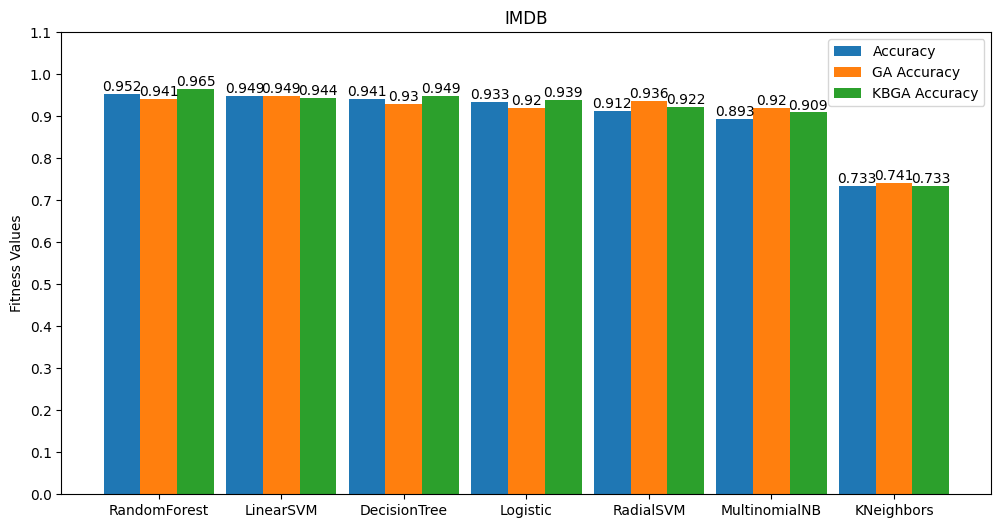

In [16]:
dataset_path = "../dataset/imdb.csv"
imdb_table = model_comparison(dataset_path, ga_imdb, kbga_imdb, 2)
hues = ['Accuracy', 'GA Accuracy', 'KBGA Accuracy']
plot_bargraphs("IMDB", imdb_table[0], hues, 1.2)
imdb_table[1]

Actual, total number of features count: 1763 - 100.0%
Selected features count from GA: 1299 - 74%
Selected features count from KBGA: 965 - 55%


,index,Accuracy,Training Time,GA Accuracy,GA - Training Time,KBGA Accuracy,KBGA - Training Time
0,Logistic,0.776,0.003,0.792,0.002,0.804,0.001
1,LinearSVM,0.776,0.041,0.808,0.031,0.816,0.023
2,MultinomialNB,0.764,0.001,0.784,0.002,0.784,0.001
3,RadialSVM,0.756,0.122,0.772,0.089,0.776,0.072
4,RandomForest,0.704,0.024,0.756,0.023,0.808,0.022
5,DecisionTree,0.684,0.000,0.692,0.001,0.764,0.001
6,KNeighbors,0.664,0.018,0.612,0.015,0.664,0.018


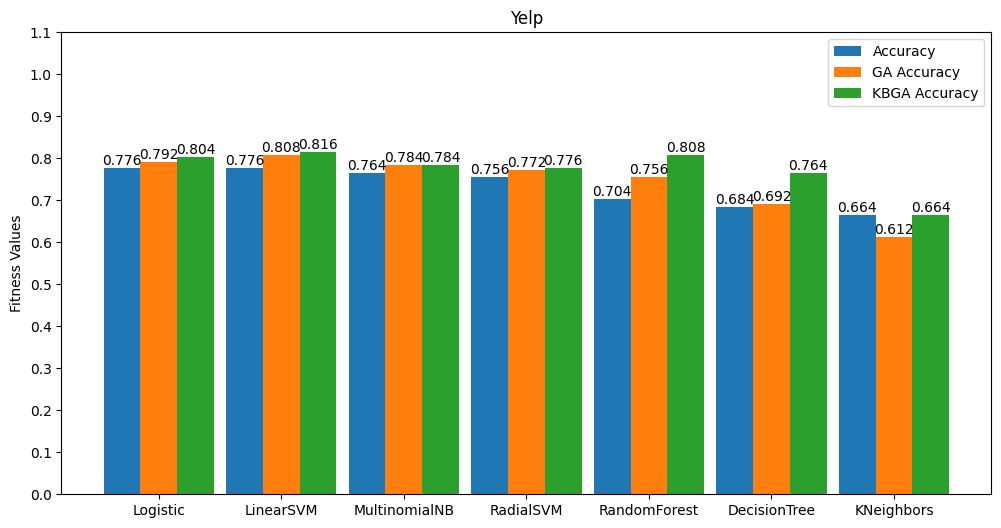

In [17]:
dataset_path = "../dataset/yelp.csv"
yelp_table = model_comparison(dataset_path, ga_yelp, kbga_yelp, 2)
hues = ['Accuracy', 'GA Accuracy', 'KBGA Accuracy']
plot_bargraphs("Yelp", yelp_table[0], hues, 1.2)
yelp_table[1]